# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler 
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import  (
    accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve, precision_score,
    recall_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings("ignore")

In [2]:
RND = 12345 

In [3]:
df = pd.read_csv('Churn.csv')

### Анализ данных

In [4]:
df.sample(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
3107,3108,15697424,Ku,597,Spain,Female,30,2.0,119370.11,1,1,1,182726.22,1
8243,8244,15572174,Mazzi,825,France,Male,29,3.0,148874.01,2,0,1,71192.82,0
2685,2686,15672115,Lettiere,679,France,Male,60,6.0,0.00,2,1,1,77331.77,0
2324,2325,15748116,Zetticci,681,France,Female,29,2.0,148143.84,1,1,1,52021.39,0
1087,1088,15696098,Palermo,498,France,Female,31,10.0,0.00,2,1,0,13892.57,0
3055,3056,15602373,White,812,France,Male,44,4.0,115049.15,2,1,0,165038.41,0
8709,8710,15713517,Otitodilinna,529,France,Male,39,NaN,102025.08,2,1,0,12351.01,0
1536,1537,15794014,Schofield,838,France,Female,34,8.0,0.00,2,1,0,27472.07,0
2553,2554,15732270,Hung,727,Spain,Male,71,8.0,0.00,1,1,1,198446.91,1
3637,3638,15809320,McElhone,845,Spain,Female,52,0.0,0.00,1,1,0,31726.76,1


In [5]:
df.columns = df.columns.str.lower()
df.columns

Index(['rownumber', 'customerid', 'surname', 'creditscore', 'geography',
       'gender', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'exited'],
      dtype='object')

In [6]:
df.columns = ['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited']


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
row_number          10000 non-null int64
customer_id         10000 non-null int64
surname             10000 non-null object
credit_score        10000 non-null int64
geography           10000 non-null object
gender              10000 non-null object
age                 10000 non-null int64
tenure              9091 non-null float64
balance             10000 non-null float64
num_of_products     10000 non-null int64
has_cr_card         10000 non-null int64
is_active_member    10000 non-null int64
estimated_salary    10000 non-null float64
exited              10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [8]:
df.describe()

,row_number,customer_id,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [9]:
df.nunique()

row_number          10000
customer_id         10000
surname              2932
credit_score          460
geography               3
gender                  2
age                    70
tenure                 11
balance              6382
num_of_products         4
has_cr_card             2
is_active_member        2
estimated_salary     9999
exited                  2
dtype: int64

In [10]:
df['exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: exited, dtype: float64

In [11]:
df['is_active_member'].value_counts(normalize=True)

1    0.5151
0    0.4849
Name: is_active_member, dtype: float64

In [12]:
df['num_of_products'].value_counts(normalize=True)

1    0.5084
2    0.4590
3    0.0266
4    0.0060
Name: num_of_products, dtype: float64

In [13]:
df['has_cr_card'].value_counts(normalize=True)

1    0.7055
0    0.2945
Name: has_cr_card, dtype: float64

In [14]:
df['geography'].value_counts(normalize=True)

France     0.5014
Germany    0.2509
Spain      0.2477
Name: geography, dtype: float64

In [15]:
df.isna().sum()

row_number            0
customer_id           0
surname               0
credit_score          0
geography             0
gender                0
age                   0
tenure              909
balance               0
num_of_products       0
has_cr_card           0
is_active_member      0
estimated_salary      0
exited                0
dtype: int64

In [16]:
df['tenure'] = df['tenure'] .fillna(df['tenure'].mean())

**В результате анализа данных можно сделать слеюдующие выводы:**
- в нашем распоряжение 10 тыс. записей о клиентах;
- из них 80 % относятся к классу клиентов, которые пользуются услугами банка и 20 % отказались от услуг банка;
- таким образом соотношение классов 1 к 5, что предполагает применение техники взвешивание классов: upsampling и downsampling;
- проверил названия столбцов к стандартному виду;
- проверили на пропуски - выявили пропуске в столбце tenure  (срок, в течение которого человек является клиентом банка в годах). Заменили на среднее значение по столбцу;
- половина клиентов из Франции и по четверти клиентов из Испании и Германии;
- примерно половину выборки составляют активные пользователи банка (is_active_member);
- 30 % клиентов имеют кредитную карту, а 70 % не имеют таковую;
- большинство клиентов пользуется 1-й или 2-я услугами банка и только 2.7 % тремя и 0.6 % - четырьмя; 
- функция плотности распределения большинства количественных величин имеют близкое к нормальному распределению за исключением:
     - возраст клиентов имеет логнормальное распределение;
     - баланс имеет нормальное распределение, но имеется выброс в 0;
     - неожиданно предполагаемый доход имеет равномерное распределение, что может говорить об искусственной генерации данной величины, так как обычно доход имеет похожее на логнормальное распределение с "тяжелым хвостом" в области высоких зарплат.


**Анализ признаков позволяет сделать следующие выводы:**
- row_number, customer_id, surname - не несут какой-то ценной информации в рамках решаемой задачи;
- среди признаком часть относится к категориальным: geography, gender, num_of_products, has_cr_card, is_active_member.
- другая часть относятся к количественным: credit_score, age (можно отнести и к категориальным величинам), tenure, balance, estimated_salary.
- сам целевой признак является категориальной величиной, поэтому предполагается решать задачу классификации.


### Преобразование данных

**Удаление незначащих признаков**

In [17]:
df = df.drop(['row_number', 'customer_id', 'surname' ], axis=1)
df

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2.00000,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.00000,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.00000,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.00000,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.00000,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5.00000,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10.00000,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7.00000,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3.00000,75075.31,2,1,0,92888.52,1


**Преобразование категориальных признаков в численные техникой прямого кодирования(One-Hot Encoding, OHE)**

In [18]:
df_ohe = pd.get_dummies(df, drop_first=True)
df_ohe

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2.00000,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.00000,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.00000,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.00000,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.00000,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5.00000,0.00,2,1,0,96270.64,0,0,0,1
9996,516,35,10.00000,57369.61,1,1,1,101699.77,0,0,0,1
9997,709,36,7.00000,0.00,1,0,1,42085.58,1,0,0,0
9998,772,42,3.00000,75075.31,2,1,0,92888.52,1,1,0,1


**Разделение выборки на обучающую, тестовую и выборку валидации**

In [19]:
target = df_ohe['exited'] # целеовой признак
features = df_ohe.drop('exited', axis=1) # признаки для обучения
features_train, features_tmp, target_train, target_tmp = train_test_split(
    features, target, test_size=0.4, stratify=target, random_state=RND)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_tmp, target_tmp, test_size=0.5,stratify=target_tmp, random_state=RND)

Проверка разделения выборки

In [20]:
print(features_train.shape, target_train.shape)
print(features_valid.shape, target_valid.shape)
print(features_test.shape, target_test.shape)

(6000, 11) (6000,)
(2000, 11) (2000,)
(2000, 11) (2000,)


**Масштабирование признаков**

In [21]:
numerics = ['credit_score', 'tenure', 'age', 'balance', 'estimated_salary']
scaler = StandardScaler()
scaler.fit(features_train[numerics]) 
features_train[numerics] = scaler.transform(features_train[numerics])
features_valid[numerics] = scaler.transform(features_valid[numerics]) 
features_test[numerics] = scaler.transform(features_test[numerics]) 

- удалили столбцы, не содержащие ценной информации для задачи МО;
- преобразовали категориальные признаки в численные техникой прямого кодирования (One-Hot Encoding, OHE);
- разделили выборку на обучающую, тестовую и выборку валидации в соотношении 60 %: 20 %: 20%;
- для части столбцов с количественными значениями признаков провели масштабирование.


## Исследование задачи

In [22]:
def decision_tree(X_train, X_valid, y_train, y_valid, cw='balanced'):
    """
    input: X_train, X_valid, y_train, y_valid - обучающие и валидационные выборки признаков и целевого признака
            cw - параметр class_weight для модели решающего дерева
    output: None
    description: функция обучает модель решающего дерева DecisionTreeClassifier с различными сочетаниями гиперпараметров;
                 метрики качества модели: f1 и roc_auc;
                 функция выводит наилучшие значения метрик и значения гиперпараметров наилучшей модели.
    """
    # в параметрах best_params_f1 и best_f1 будем хранить наилучшие параметры для модели и наивысшую f1 метрику соответственно
    best_params_f1 = []
    best_f1 = 0
    # аналогично для roc_auc метрики.
    best_params_roc_auc = []
    best_roc_auc = 0.5
    # проходим в циклах по всем выбранным гиперпараметрам
    for max_depth in range(4,10):
        for min_samples_split in range(5,15):
            for min_samples_leaf in range(5,10):
                for criterion in ['gini', 'entropy']:
                    # инициация модели с текущими гиперпараметрами
                    model_dt_clf = DecisionTreeClassifier(random_state=RND,
                                                          max_depth=max_depth,
                                                          min_samples_split=min_samples_split,
                                                          min_samples_leaf=min_samples_leaf,
                                                          criterion=criterion,
                                                          class_weight=cw)
                    # обучение модели на тренировочной выборке
                    model_dt_clf.fit(X_train, y_train)
                    # поиск предсказаний модели на валидационной выбоке
                    predictions = model_dt_clf.predict(X_valid)
                    # получение вероятностей классов для расчета roc_auc
                    probabilities_valid = model_dt_clf.predict_proba(X_valid)
                    # вычисление f1 модели методом f1_score
                    f1 = f1_score(y_valid, predictions)
                    # если текущее значение метрики f1 выше предыдущего лучшего значения, 
                    # сохраняем параметры модели и текущую метрику f1
                    if f1 > best_f1:
                        best_params_f1 = [max_depth, min_samples_split, min_samples_leaf, criterion]
                        best_f1 = f1
                    # аналогично для метрики roc_auc
                    roc_auc = roc_auc_score(y_valid, probabilities_valid[:, 1])
                    if roc_auc > best_roc_auc:
                        best_params_roc_auc = [max_depth, min_samples_split, min_samples_leaf, criterion]
                        best_roc_auc = roc_auc
    
    # вывод наилучшей метрики f1 и параметров модели.
    print('''Наилучшая метрика f1: {}
    Параметры модели:
       max_depth = {}
       min_samples_split = {}
       min_samples_leaf = {}
       criterion = {} \n'''.format(round(best_f1, 3),
                                 best_params_f1[0],
                                 best_params_f1[1],
                                 best_params_f1[2],
                                 best_params_f1[3]
                                ))
    
    # вывод наилучшей метрики roc_auc и параметров модели.
    print('''Наилучшая метрика roc_auc: {}
    Параметры модели:
       max_depth = {}
       min_samples_split = {}
       min_samples_leaf = {}
       criterion = {} '''.format(round(best_roc_auc, 3),
                                 best_params_roc_auc[0],
                                 best_params_roc_auc[1],
                                 best_params_roc_auc[2],
                                 best_params_roc_auc[3]
                                ))

In [23]:
decision_tree(features_train, features_valid,target_train, target_valid, cw=None)

Наилучшая метрика f1: 0.603
    Параметры модели:
       max_depth = 6
       min_samples_split = 5
       min_samples_leaf = 6
       criterion = entropy 

Наилучшая метрика roc_auc: 0.859
    Параметры модели:
       max_depth = 7
       min_samples_split = 5
       min_samples_leaf = 6
       criterion = entropy 


In [24]:
decision_tree(features_train, features_valid,target_train, target_valid)

Наилучшая метрика f1: 0.617
    Параметры модели:
       max_depth = 8
       min_samples_split = 5
       min_samples_leaf = 7
       criterion = entropy 

Наилучшая метрика roc_auc: 0.861
    Параметры модели:
       max_depth = 7
       min_samples_split = 5
       min_samples_leaf = 7
       criterion = entropy 


**Итоги по алгоритму Дерево решений**

Привели расчет f1-меры для алгоритма МО Дерево решений. На выборке валидации лучшей результат показала модель, для которой выставлен параметр балансировки по классам.

**С параметром балансировки классов равным None**
- Наилучшая метрика f1: 0.603
- Параметры модели:
       - max_depth = 6
       - min_samples_split = 5
       - min_samples_leaf = 6
       - criterion = entropy 

- Наилучшая метрика roc_auc: 0.859
- Параметры модели:
       - max_depth = 7
       - min_samples_split = 5
       - min_samples_leaf = 6
       - criterion = entropy 
       
**С параметром балансировки классов равным balanced**       
- Наилучшая метрика f1: 0.617
- Параметры модели:
       - max_depth = 8
       - min_samples_split = 5
       - min_samples_leaf = 7
       - criterion = entropy 

- Наилучшая метрика roc_auc: 0.861
- Параметры модели:
       - max_depth = 7
       - min_samples_split = 5
       - min_samples_leaf = 7
       - criterion = entropy 

In [25]:
def random_forest(X_train, X_valid, y_train, y_valid, cw='balanced'):
    """
    input: X_train, X_valid, y_train, y_valid - обучающие и валидационные выборки признаков и целевого признака
            cw - параметр class_weight для модели случайного леса
    output: None
    description: функция обучает модель решающего дерева RandomForestClassifier с различными сочетаниями гиперпараметров;
                 метрики качества модели: f1 и roc_auc;
                 функция выводит наилучшие значения метрик и значения гиперпараметров наилучшей модели.
    """
    # в параметрах best_params_f1 и best_f1 будем хранить наилучшие параметры для модели и наивысшую f1 метрику соответственно
    best_params_f1 = []
    best_f1 = 0
    # аналогично для roc_auc метрики.
    best_params_roc_auc = []
    best_roc_auc = 0.5
    # проходим в циклах по всем выбранным гиперпараметрам
    for n_estimators in range(40,140,10):
        for max_depth in range(2,12):
                    # инициация модели с текущими гиперпараметрами
                    model_rf_clf = RandomForestClassifier(random_state=RND,
                                                          n_estimators=n_estimators,
                                                          max_depth=max_depth,
                                                          class_weight=cw)
                    # обучение модели на тренировочной выборке
                    model_rf_clf.fit(X_train, y_train)
                    # поиск предсказаний модели на валидационной выбоке
                    predictions = model_rf_clf.predict(X_valid)
                    # получение вероятностей классов для расчета roc_auc
                    probabilities_valid = model_rf_clf.predict_proba(X_valid)
                    # вычисление f1 модели методом f1_score
                    f1 = f1_score(y_valid, predictions)
                    # если текущее значение метрики f1 выше предыдущего лучшего значения, 
                    # сохраняем параметры модели и текущую метрику f1
                    if f1 > best_f1:
                        best_params_f1 = [n_estimators, max_depth]
                        best_f1 = f1
                    # аналогично для метрики roc_auc
                    roc_auc = roc_auc_score(y_valid, probabilities_valid[:, 1])
                    if roc_auc > best_roc_auc:
                        best_params_roc_auc = [n_estimators, max_depth]
                        best_roc_auc = roc_auc

    # вывод наилучшей метрики f1 и параметров модели.
    print('''Наилучшая метрика f1: {}
    Парамтеры модели:
       n_estimators = {}
       max_depth = {}
       \n'''.format(round(best_f1, 3),
                                 best_params_f1[0],
                                 best_params_f1[1]                                 
                                ))

    # вывод наилучшей метрики roc_auc и параметров модели.
    print('''Наилучшая метрика roc_auc: {}
    Парамтеры модели:
       n_estimators = {}
       max_depth = {}
       '''.format(round(best_roc_auc, 3),
                                 best_params_roc_auc[0],
                                 best_params_roc_auc[1]
                                       ))

In [26]:
random_forest(features_train, features_valid,target_train, target_valid, cw=None)

Наилучшая метрика f1: 0.602
    Парамтеры модели:
       n_estimators = 40
       max_depth = 11
       

Наилучшая метрика roc_auc: 0.875
    Парамтеры модели:
       n_estimators = 130
       max_depth = 9
       


In [27]:
random_forest(features_train, features_valid,target_train, target_valid, cw='balanced')

Наилучшая метрика f1: 0.649
    Парамтеры модели:
       n_estimators = 110
       max_depth = 9
       

Наилучшая метрика roc_auc: 0.871
    Парамтеры модели:
       n_estimators = 100
       max_depth = 7
       


**Итоги по алгоритму Случайный лес**

Привели расчет f1-меры для алгоритма МО Случайный лес. На выборке валидации лучшей результат показала модель, для которой выставлен параметр балансировки по классам.

**С параметром балансировки классов равным None**

- Наилучшая метрика f1: 0.602
- Парамтеры модели:
       - n_estimators = 40
       - max_depth = 11
      
- Наилучшая метрика roc_auc: 0.875
- Парамтеры модели:
       - n_estimators = 130
       - max_depth = 9
       
**С параметром балансировки классов равным balanced**       

- Наилучшая метрика f1: 0.649
- Парамтеры модели:
       - n_estimators = 110
       - max_depth = 9
       

- Наилучшая метрика roc_auc: 0.871
- Парамтеры модели:
       - n_estimators = 100
       - max_depth = 7

In [28]:
def log_reg(X_train, X_valid, y_train, y_valid, cw='balanced'):
    """
    input: X_train, X_valid, y_train, y_valid - обучающие и валидационные выборки признаков и целевого признака
            cw - параметр class_weight для модели логистической регрессии
    output: None
    description: функция обучает модель логистической регрессии LogisticRegression с различными сочетаниями гиперпараметров;
                 метрики качества модели: f1 и roc_auc;
                 функция выводит наилучшие значения метрик и значения гиперпараметров наилучшей модели.
    """
    # в параметрах best_params_f1 и best_f1 будем хранить наилучшие параметры для модели и наивысшую f1 метрику соответственно
    best_params_f1 = []
    best_f1 = 0
    # аналогично для roc_auc метрики.
    best_params_roc_auc = []
    best_roc_auc = 0.5
    # проходим в циклах по всем выбранным гиперпараметрам
    for C in range(1, 10):
        # инициация модели с текущими гиперпараметрами
        model_lr_clf = LogisticRegression(random_state=RND,
                                      C=C,
                                      max_iter=100,
                                      class_weight=cw,
                                      solver='liblinear')
        # обучение модели на тренировочной выборке
        model_lr_clf.fit(X_train, y_train)
        # поиск предсказаний модели на валидационной выбоке
        predictions = model_lr_clf.predict(X_valid)
        # получение вероятностей классов для расчета roc_auc
        probabilities_valid = model_lr_clf.predict_proba(X_valid)
        # вычисление f1 модели методом f1_score
        f1 = f1_score(y_valid, predictions)
        # если текущее значение метрики f1 выше предыдущего лучшего значения, 
        # сохраняем параметры модели и текущую метрику f1
        if f1 > best_f1:
            best_params_f1 = [C]
            best_f1 = f1
        # аналогично для метрики roc_auc
        roc_auc = roc_auc_score(y_valid, probabilities_valid[:, 1])
        if roc_auc > best_roc_auc:
            best_params_roc_auc = [C]
            best_roc_auc = roc_auc     
    # вывод наилучшей метрики f1 и параметров модели.
    print('''Наилучшая метрика f1: {}
    Парамтеры модели:
       Inverse of regularization strength = {}
       \n'''.format(round(best_f1, 3),
                                 best_params_f1[0]
                               ))

    # вывод наилучшей метрики roc_auc и параметров модели.
    print('''Наилучшая метрика roc_auc: {}
    Парамтеры модели:
       Inverse of regularization strength = {}
        '''.format(round(best_roc_auc, 3),
                                 best_params_roc_auc[0]
                              
                                ))

In [29]:
log_reg(features_train, features_valid,target_train, target_valid, cw=None)

Наилучшая метрика f1: 0.311
    Парамтеры модели:
       Inverse of regularization strength = 2
       

Наилучшая метрика roc_auc: 0.787
    Парамтеры модели:
       Inverse of regularization strength = 8
        


In [30]:
log_reg(features_train, features_valid,target_train, target_valid, cw='balanced')

Наилучшая метрика f1: 0.529
    Парамтеры модели:
       Inverse of regularization strength = 1
       

Наилучшая метрика roc_auc: 0.794
    Парамтеры модели:
       Inverse of regularization strength = 1
        



**Итоги по алгоритму Случайный лес**

Привели расчет f1-меры для алгоритма МО Логистическая регрессия. На выборке валидации лучший результат показала модель, для которой выставлен параметр балансировки по классам. Но данная модель показала худшие результаты даже на выборке валидации, поэтому из дальнейшего рассмотрения ее исключим. Видимо виной всему неудачное название - "регрессия"))), а мы тут классифицировать пытаемся))  

**С параметром балансировки классов равным None**
- Наилучшая метрика f1: 0.311
- Наилучшая метрика roc_auc: 0.787

**С параметром балансировки классов равным balanced**       
- Наилучшая метрика f1: 0.529
- Наилучшая метрика roc_auc: 0.794



### Выводы


- Провели обучение 3-х моделей машинного обучения с параметром балансировки классов равным balanced и None;
- Результаты показали, что параметр балансировки классов balanced показал лучшие результаты;
- Среди моделей наилучший результат на выборке валидации показала модель МО Случайный лес с наилучшим значением метрики f1: 0.649;
- хорошие результаты показала модель МО Дерево решений;
- модель логистической регрессии не предполагается использовать для решения этой задачи в виду низких результатов.



## Борьба с дисбалансом

### Увеличение выборки по классу 1

In [31]:
def upsample(features, target, repeat):

    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    #произведем перемешивание выборки для лучшего обучения
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=RND)
    return features_upsampled, target_upsampled

In [32]:
features_train_up, target_train_up = upsample(features_train, target_train, 4) 
# так как дисбаланс между классами 1 к 4, то повторим строки со значеними целеового признака 4 раза

In [33]:
(target_train_up[target_train_up == 0].shape[0])/(target_train_up[target_train_up == 1].shape)[0]

0.9774959083469722

Соотношение классов в результате получилось около единицы, что и требовалось получить

In [34]:
decision_tree(features_train_up, features_valid,target_train_up, target_valid, cw=None)

Наилучшая метрика f1: 0.591
    Параметры модели:
       max_depth = 8
       min_samples_split = 5
       min_samples_leaf = 7
       criterion = entropy 

Наилучшая метрика roc_auc: 0.851
    Параметры модели:
       max_depth = 6
       min_samples_split = 5
       min_samples_leaf = 8
       criterion = entropy 


In [35]:
random_forest(features_train_up, features_valid,target_train_up, target_valid, cw=None)

Наилучшая метрика f1: 0.649
    Парамтеры модели:
       n_estimators = 70
       max_depth = 10
       

Наилучшая метрика roc_auc: 0.873
    Парамтеры модели:
       n_estimators = 130
       max_depth = 9
       


Применение метода upsample не позволило получить лучшие результаты на выборке валидации. Для Дерева решений результат оказался хуже, а для Случайного леса - результат аналогичный.

### Уменьшение выборки по классу 0

In [36]:
def downsample(features, target, fraction):

    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=RND)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=RND)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=RND)
    return features_downsampled, target_downsampled

In [37]:
features_train_dn, target_train_dn = downsample(features_train, target_train, 0.25)

In [38]:
features_train_dn[target_train_dn == 0].shape


(1194, 11)

In [39]:
features_train_dn[target_train_dn == 1].shape

(1222, 11)

In [40]:
decision_tree(features_train_dn, features_valid,target_train_dn, target_valid, cw=None)

Наилучшая метрика f1: 0.602
    Параметры модели:
       max_depth = 8
       min_samples_split = 5
       min_samples_leaf = 9
       criterion = gini 

Наилучшая метрика roc_auc: 0.854
    Параметры модели:
       max_depth = 6
       min_samples_split = 5
       min_samples_leaf = 9
       criterion = gini 


In [41]:
random_forest(features_train_dn, features_valid,target_train_dn, target_valid, cw=None)

Наилучшая метрика f1: 0.634
    Парамтеры модели:
       n_estimators = 40
       max_depth = 6
       

Наилучшая метрика roc_auc: 0.869
    Парамтеры модели:
       n_estimators = 120
       max_depth = 7
       


Применение метода downsample не позволило получить лучшие результаты на выборке валидации. 

### Вывод

Применение методов downsample и upsample не позволило получить лучшие результаты по сравнению с применением параметра class_weight = balanced на выборке валидации

## Тестирование модели

### Деревое решений 

#### Дерево решений со стандартной  для метода балансировкой по классам 

In [42]:
model_dt_clf = DecisionTreeClassifier(random_state=RND,
                                      max_depth=8,
                                      min_samples_split=5,
                                      min_samples_leaf=7,
                                      criterion='entropy' ,
                                      class_weight='balanced')
          
model_dt_clf.fit(features_train, target_train)
predictions = model_dt_clf.predict(features_test)
f1 = f1_score(target_test, predictions)
print("f1 = {:.3f}".format(f1))

f1 = 0.576


#### Дерево решений с балансировкой по классам на освоме метода upsample

In [43]:
model_dt_clf = DecisionTreeClassifier(random_state=RND,
                                                          max_depth=8,
                                                          min_samples_split=5,
                                                          min_samples_leaf=7,
                                                          criterion='entropy' ,
                                                         )
          
model_dt_clf.fit(features_train_up, target_train_up)
predictions = model_dt_clf.predict(features_test)
f1 = f1_score(target_test, predictions)
print("f1 = {:.3f}".format(f1))

f1 = 0.567


#### Дерево решений с балансировкой по классам на освоме метода downsample

In [44]:
model_dt_clf = DecisionTreeClassifier(random_state=RND,
                                                          max_depth=8,
                                                          min_samples_split=5,
                                                          min_samples_leaf=9,
                                                          criterion='gini' ,
                                                         )
          
model_dt_clf.fit(features_train_dn, target_train_dn)
predictions = model_dt_clf.predict(features_test)
f1 = f1_score(target_test, predictions)
print("f1 = {:.3f}".format(f1))

f1 = 0.549


Деревья решений (классификации) показали плохой результат на тестовой выборке по причине переобучения. Данную проблему можно частично решить за счет кросс-валидации или применения алгоритма МО Случайного леса, который менее склонен к переобучению

 ### Случайный лес

#### Случайный лес со стандартной  для метода балансировкой по классам

In [45]:
model_rf_clf = RandomForestClassifier(random_state=RND,
                                    n_estimators=110,
                                    max_depth=9,
                                    class_weight='balanced')
# обучение модели на тренировочной выборке
model_rf_clf.fit(features_train, target_train)
# поиск предсказаний модели на валидационной выбоке
predictions = model_rf_clf.predict(features_test)
# вычисление f1 модели методом f1_score
f1 = f1_score(target_test, predictions)
print("f1 = {:.4f}".format(f1))

f1 = 0.6126


In [46]:
#функция для построения ROC-кривой и расчета показателя ROC-AUC
def roc_curve_plot(model, name): 
    p_test = model.predict_proba(features_test)
    p_test = p_test[:, 1]
    auc_roc = roc_auc_score(target_test, p_test)
    fpr, tpr, thresholds = roc_curve(target_test, p_test)
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, color='mediumblue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='firebrick')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая модели {}'.format(name))    
    plt.show()
    print('AUC-ROC модели {} = {:.3}'.format(name, auc_roc))

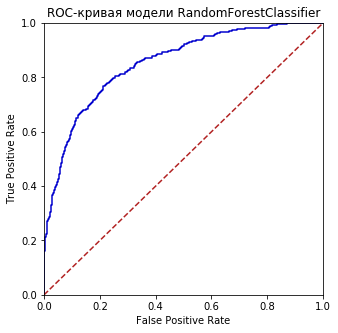

AUC-ROC модели RandomForestClassifier = 0.853


In [47]:
roc_curve_plot(model_rf_clf, 'RandomForestClassifier')

#### Случайный лес  с балансировкой классам на освоме метода upsample

In [48]:
model_rf_clf = RandomForestClassifier(random_state=RND,
                                    n_estimators=70,
                                    max_depth=10,
                                   )
# обучение модели на тренировочной выборке
model_rf_clf.fit(features_train_up, target_train_up)
# поиск предсказаний модели на валидационной выбоке
predictions = model_rf_clf.predict(features_test)
# вычисление f1 модели методом f1_score
f1 = f1_score(target_test, predictions)
print("f1 = {:.3f}".format(f1))

f1 = 0.608


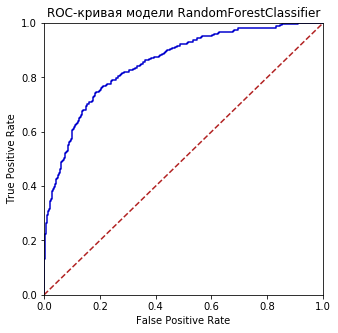

AUC-ROC модели RandomForestClassifier = 0.852


In [49]:
roc_curve_plot(model_rf_clf, 'RandomForestClassifier')

#### Случайный лес с балансировкой классам на освоме метода downsample

In [50]:
model_rf_clf = RandomForestClassifier(random_state=RND,
                                    n_estimators=40,
                                    max_depth=6,
                                    )
# обучение модели на тренировочной выборке
model_rf_clf.fit(features_train_dn, target_train_dn)
# поиск предсказаний модели на валидационной выбоке
predictions = model_rf_clf.predict(features_test)
# вычисление f1 модели методом f1_score
f1 = f1_score(target_test, predictions)
print("f1 = {:.4f}".format(f1))

f1 = 0.5803


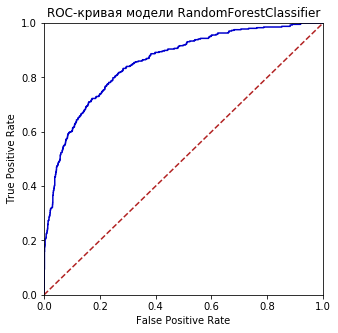

AUC-ROC модели RandomForestClassifier = 0.855


In [51]:
roc_curve_plot(model_rf_clf, 'RandomForestClassifier')

На тестовой выборке для моделей МО Случайный лес результаты заметно упали. Хотя модель Случайный лес менее склонна к переобучению чем Дерево решений, но, видимо, Случайный лес переобучился на выборке валидации. Хуже всего показал себя метод с балансировкой классам на основе метода downsample. Два других метода для работы с балансировкой показали аналогичную точность на тестовой выборке 0.613 и 0.608 (upsample).
Значение метрики AUC-ROC для всех трех моделей МО Случайный лес получились близкие, данная метрика позволяет выявить потенциального хорошие алгоритмы, которые можно еще немного улучшить. 

### Вывод


В результате проверки на тестовой выборке можно сделать следующие выводы:
- модели МО Дерево решений переобучились и показали значительно худшие результаты на тестовой выборке чем на выборке валидации. При работе с данными моделями целесообразно подбирать параметры так  чтобы уменьшить вероятность переобучения. Например, можно уменьшать глубину дерева, увеличивать минимальное число элементов в листе, увеличивать минимальное число элементов в узле для разделения. Но сложная подгонка для данных моделей не имеет большого смысла в виду наличия Случайных лесов;
- модели Случайного леса показали результаты тоже более низкие по сравнению с выборкой валидации, но в целом результат удовлетворяет поставленному требованию в 0.59;
- применение методов downsample и upsample не имеет большого преимущество по сравнению с выставлением параметра обучения моделей class_weight = balanced, аналогичный вывод был получен и на выборке валидации.
- значение метрики AUC-ROC для всех трех моделей МО Случайный лес получились близкие, данная метрика позволяет выявить потенциального хорошие алгоритмы, которые можно еще немного улучшить. 


## Дополнительные методы 

### Проверка качества в зависимости от числа деревьем

In [52]:
#  генерим список для количества деревьев
n = []
i1 = 10
for i in range(45):
    n.append(int(i1))
    i1*=1.07


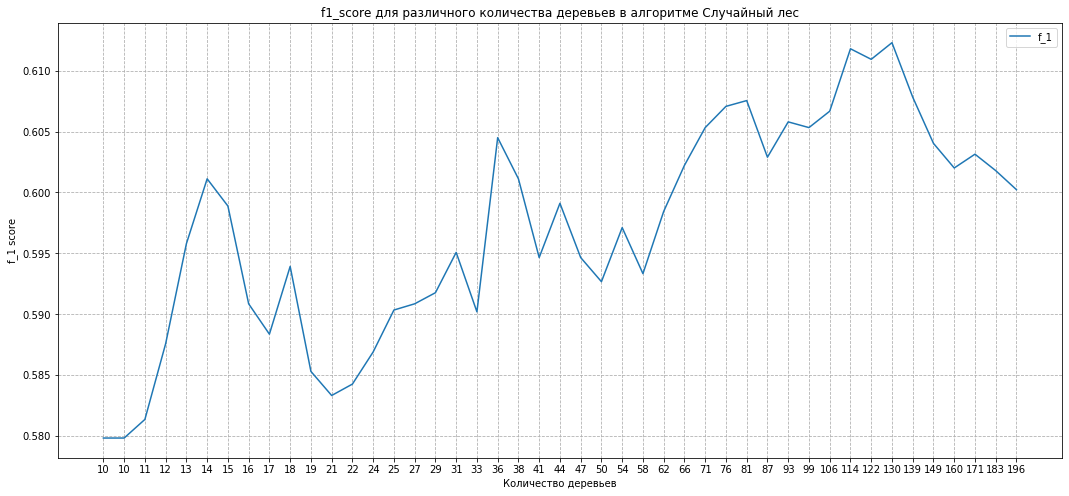

In [53]:
models = [RandomForestClassifier(n_estimators=x,max_depth=10,random_state=RND).fit(features_train_up, target_train_up) for x in n]
f_1 = [f1_score(target_test, models[x].predict(features_test)) for x in range(len(n))]
fig, ax = plt.subplots(figsize=(18,8))
ax.plot(range(len(n)),f_1,label='f_1')
ax.set_xticks(range(len(n)))
ax.set_xticklabels(n)
ax.set_xlabel('Количество деревьев')
ax.set_ylabel('f_1 score')
ax.grid(linestyle='--')
ax.legend()
ax.set_title('f1_score для различного количества деревьев в алгоритме Случайный лес')
plt.close('all')
fig

Из анализа графика можно сделать вывод, что при увеличении числа деревьев в алгоритме МО Случайный лес наблюдается тенденция к увеличению показателя f1. Но увеличение числа деревьев примерно больше 130 не дает существенного выигрыша в качестве, но усложняет модель. Вместе с тем небольшое количество деревьев (примерно до 33) может привести к неустойчивому качеству решений и может опуститься ниже требуемого значения 0.59

### Повышение качества за счет смещения порога

In [54]:
# функция для расчета f1_score для различных значений порога
def count_threshold (probabilities_one_valid):
    for threshold in np.arange(0.44, 0.52, 0.005):
        predicted_valid = probabilities_one_valid > threshold
        f1 = f1_score(target_valid, predicted_valid)
        print("Порог = {:.3f} | F1 = {:.3f}".format(
        threshold, f1))

In [55]:
#выбрали лучшую модель Случайный лес со стандартной  для метода балансировкой по классам
model = RandomForestClassifier(n_estimators=110, max_depth=9, random_state=RND, class_weight='balanced')
model.fit(features_train, target_train)
probabilities_valid_forest = model.predict_proba(features_valid)
probabilities_one_valid_forest = probabilities_valid_forest[:, 1]

In [56]:
count_threshold (probabilities_one_valid_forest)

Порог = 0.440 | F1 = 0.640
Порог = 0.445 | F1 = 0.641
Порог = 0.450 | F1 = 0.644
Порог = 0.455 | F1 = 0.644
Порог = 0.460 | F1 = 0.647
Порог = 0.465 | F1 = 0.648
Порог = 0.470 | F1 = 0.648
Порог = 0.475 | F1 = 0.650
Порог = 0.480 | F1 = 0.651
Порог = 0.485 | F1 = 0.648
Порог = 0.490 | F1 = 0.649
Порог = 0.495 | F1 = 0.648
Порог = 0.500 | F1 = 0.649
Порог = 0.505 | F1 = 0.648
Порог = 0.510 | F1 = 0.645
Порог = 0.515 | F1 = 0.646
Порог = 0.520 | F1 = 0.648


In [57]:
probabilities_test = model.predict_proba(features_test)
probabilities_test = probabilities_test[:, 1]
probabilities_test = probabilities_test > 0.48
f1 = f1_score(target_test, probabilities_test)
print("Порог = {:.2f} | f1 = {:.4f}".format(
        0.48, f1))

Порог = 0.48 | f1 = 0.6135


В результате подгонки порога принятия решений на выборке валидации на тестовой выборке получилось улучшить f1_score на 0.6135 - 0.6126 = 0.009, что говорит от том, что получен малозначимый результат.

In [58]:
# модель показавшая высокое значение метрики AUC-ROC, но не очень хороший результат по f1_score
# Случайный лес с балансировкой классам на освоме метода downsample
model = RandomForestClassifier(n_estimators=40, max_depth=6, random_state=RND)
model.fit(features_train_dn, target_train_dn)
probabilities_valid_forest = model.predict_proba(features_valid)
probabilities_one_valid_forest = probabilities_valid_forest[:, 1]

In [59]:
count_threshold (probabilities_one_valid_forest)

Порог = 0.440 | F1 = 0.584
Порог = 0.445 | F1 = 0.587
Порог = 0.450 | F1 = 0.592
Порог = 0.455 | F1 = 0.597
Порог = 0.460 | F1 = 0.599
Порог = 0.465 | F1 = 0.604
Порог = 0.470 | F1 = 0.613
Порог = 0.475 | F1 = 0.618
Порог = 0.480 | F1 = 0.621
Порог = 0.485 | F1 = 0.625
Порог = 0.490 | F1 = 0.627
Порог = 0.495 | F1 = 0.628
Порог = 0.500 | F1 = 0.634
Порог = 0.505 | F1 = 0.634
Порог = 0.510 | F1 = 0.632
Порог = 0.515 | F1 = 0.631
Порог = 0.520 | F1 = 0.633


In [65]:
probabilities_test = model.predict_proba(features_test)
probabilities_test = probabilities_test[:, 1]
probabilities_test = probabilities_test > 0.505
f1 = f1_score(target_test, probabilities_test)
print("Порог = {:.3f} | f1 = {:.4f}".format(
        0.505, f1))

Порог = 0.505 | f1 = 0.5826


В результате подгонки порога принятия решений на выборке валидации на тестовой выборке получилось улучшить f1_score на 0.5826 - 0.5803 = 0.023, что говорит от том что получен незначемый результат. Вывод о том, что данный алгоритм можно улучшить сделан на основе метрики AUC-ROC.

## Общий вывод

- в нашем распоряжение 10 тыс. записей о клиентах, из них 80 % относятся к классу клиентов, которые пользуются услугами банка и 20 % отказались от услуг банка,  таким образом соотношение классов 1 к 5;
- проверили на пропуски - выявили пропуске в столбце tenure  (срок, в течение которого человек является клиентом банка в годах). Заменили на среднее значение по столбцу;
- Провели подготовку данных для МО:  удалили столбцы, не содержащие ценной информации для задачи МО;  преобразовали категориальные признаки в численные техникой прямого кодирования (One-Hot Encoding, OHE);  разделили выборку на обучающую, тестовую и выборку валидации в соотношении 60 %: 20 %: 20%; - для части столбцов с количественными значениями признаков провели масштабирование.
- Провели обучение 3-х моделей машинного обучения с параметром балансировки классов равным balanced и None;
- Результаты показали, что параметр балансировки классов balanced показал лучшие результаты.  Среди моделей наилучший результат на выборке валидации показала модель МО Случайный лес с наилучшим значением метрики f1: 0.649. Хорошие результаты показала модель МО Дерево решений. Модель логистической регрессии не предполагается использовать для решения этой задачи в виду низких результатов.
- Применение методов downsample и upsample не позволило получить лучшие результаты по сравнению с применением параметра class_weight = balanced. 
- В результате проверки на тестовой выборке можно сделать следующие выводы:модели МО Дерево решений переобучились и показали значительно худшие результаты на тестовой выборке чем на выборке валидации. При работе с данными моделями целесообразно подбирать параметры так чтобы уменьшить вероятность переобучения. Например, можно уменьшать глубину дерева, увеличивать минимальное число элементов в листе, увеличивать минимальное число элементов в узле для разделения. Но сложная подгонка для данных моделей не имеет большого смысла в виду наличия Случайных лесов. Модели Случайного леса показали результаты тоже более низкие по сравнению с выборкой валидации, но в целом результат удовлетворяет поставленному требованию в 0.59. Лучший резултат получен для алгоритма Случайный лес со стандартной  для метода балансировкой 0.6126.
- применение методов downsample и upsample не имеют большого преимущество по сравнению с выставлением параметра обучения моделей class_weight = balanced, аналогичный вывод был получен и на выборке валидации.
- При увеличении числа деревьев в алгоритме МО Случайный лес наблюдается тенденция к увеличению показателя f1. Но увеличение числа деревьев примерно больше 130 не дает существенного выигрыша в качестве, но усложняет модель. Вместе с тем небольшое количество деревьев (примерно до 33) может привести к неустойчивому качеству решений и может опуститься ниже требуемого значения 0.59
- Для алгоритма Случайный лес со стандартной  для метода балансировкой:  В результате подгонки порога для принятия решений на выборке валидации на тестовой выборке получилось улучшить f1_score на 0.6135 - 0.6126 = 0.009, что говорит от том, что получен малозначимый результат.
- Для алгоритма Случайный лес с балансировкой классам на основе метода downsample. В результате подгонки порога принятия решений на выборке валидации на тестовой выборке получилось улучшить f1_score на 0.5826 - 0.5803 = 0.023, что говорит от том, что получен незначемый результат. Вывод о том, что данный алгоритм можно улучшить сделан на основе метрики AUC-ROC.
- В рузультеты был получен алгоритм МО обучения удовлетворяющий требованию в 0.59. Лучший алгоритм показал рузультат 0.6135. 